In [1]:
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data

In [2]:
result_loc = 'data/{}/BetaE/{}/{}seed_{}C0_{}C1_{}sec_{}param_{}reg_{}epochs/metric_results_{}.csv'
metric = 'inverse_harmonic_mean_rank'
side = 'tail'
metric_type = 'realistic'

seeds = [134]
epochs = [250]
difficulties = ['easy']
models = ['BetaeExtensionStructuredEmbedding', 'BetaeExtensionTransE','BetaeExtensionTranslational']
datasets = ['FB15k-237']
cochain_dims = [[8,8], [16,16], [32,32], [64,64], [32,16], [32,8]]
sections = [1, 16, 32]
reg_weights = [0, 1e-2, 1e-1, 1]
parametrizations = [None, 'orthogonal']

In [3]:
experiments = itertools.product(models, datasets, cochain_dims, sections, reg_weights, parametrizations, epochs, difficulties, seeds)

In [4]:
dfs = []
i = 0
for experiment in experiments:
    model = experiment[0]
    dataset = experiment[1]
    c0_dim = experiment[2][0]
    c1_dim = experiment[2][1]
    num_sections = experiment[3]
    reg_weight = experiment[4]
    parametrization = experiment[5]
    num_epochs = experiment[6]
    difficulty = experiment[7]
    random_seed = experiment[8]

    loc = result_loc.format(dataset, model, random_seed, c0_dim, c1_dim, num_sections, parametrization, reg_weight, num_epochs, difficulty)
    skipped = []
    try:
        df = pd.read_csv(loc)
        df[['model', 'dataset','c0_dim','c1_dim','num_sections','reg_weight','parametrization','num_epochs','difficulty','random_seed']] = \
        [model,dataset,c0_dim,c1_dim,num_sections,reg_weight,parametrization,num_epochs,difficulty,random_seed]
        dfs.append(df)
        i += 1
    except FileNotFoundError as e:
        skipped.append(experiment)
print(f'captured {i} files')
dfs = pd.concat(dfs, axis=0, ignore_index=True).drop('Unnamed: 0', axis=1)


captured 115 files


In [5]:
dfs

,Side,Type,Metric,Value,query_structure,model,dataset,c0_dim,c1_dim,num_sections,reg_weight,parametrization,num_epochs,difficulty,random_seed
0,head,optimistic,inverse_geometric_mean_rank,0.029346,test,BetaeExtensionStructuredEmbedding,FB15k-237,8,8,32,0.0,None,250,easy,134
1,tail,optimistic,inverse_geometric_mean_rank,0.029430,test,BetaeExtensionStructuredEmbedding,FB15k-237,8,8,32,0.0,None,250,easy,134
2,both,optimistic,inverse_geometric_mean_rank,0.029388,test,BetaeExtensionStructuredEmbedding,FB15k-237,8,8,32,0.0,None,250,easy,134
3,head,realistic,inverse_geometric_mean_rank,0.029346,test,BetaeExtensionStructuredEmbedding,FB15k-237,8,8,32,0.0,None,250,easy,134
4,tail,realistic,inverse_geometric_mean_rank,0.029430,test,BetaeExtensionStructuredEmbedding,FB15k-237,8,8,32,0.0,None,250,easy,134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146620,both,optimistic,adjusted_hits_at_k,0.000181,ip,BetaeExtensionTranslational,FB15k-237,32,8,32,1.0,None,250,easy,134
146621,tail,realistic,adjusted_hits_at_k,-0.000039,ip,BetaeExtensionTranslational,FB15k-237,32,8,32,1.0,None,250,easy,134
146622,both,realistic,adjusted_hits_at_k,-0.000039,ip,BetaeExtensionTranslational,FB15k-237,32,8,32,1.0,None,250,easy,134
146623,tail,pessimistic,adjusted_hits_at_k,-0.000039,ip,BetaeExtensionTranslational,FB15k-237,32,8,32,1.0,None,250,easy,134


In [6]:
# rename orthogonal param models
model_rename = {'BetaeExtensionStructuredEmbedding':'ExtensionSE', 'BetaeExtensionTranslational':'ExtensionTranslational','BetaeExtensionTransE':'ExtensionTransE'}
dfs['model'] = dfs['model'].apply(lambda x: model_rename[x])
dfs['model'] = dfs.apply(lambda x: f"{x['model']}_{x['parametrization']}" if x['parametrization'] is not None else x['model'], axis=1)
metric_dfs = dfs[(dfs['Metric'] == metric) & (dfs['Type'] == metric_type) & (dfs['Side'] == side)].rename({'Value':metric}, axis=1)

# Plot Data

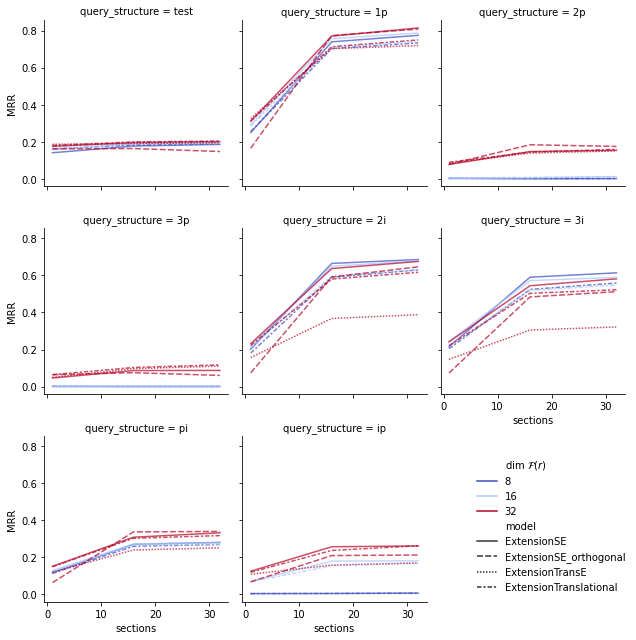

In [7]:
this_metric_dfs = metric_dfs[(metric_dfs['c0_dim'] == 32) & (metric_dfs['reg_weight'] == 0)].copy()
cr = {'num_sections':'sections', 
            'c1_dim':'dim $\mathcal{F}(r)$',
            metric:'MRR'}
this_metric_dfs.rename(cr, axis=1, inplace=True)
g = sns.relplot(
    data=this_metric_dfs, x=cr['num_sections'], y=cr[metric], col='query_structure', style='model',
    kind="line", height=3, col_wrap=3, hue=cr['c1_dim'], palette='coolwarm', err_style=None, alpha=0.7
)
sns.move_legend(g, "upper left", bbox_to_anchor=(.6, 0.3))
plt.show()

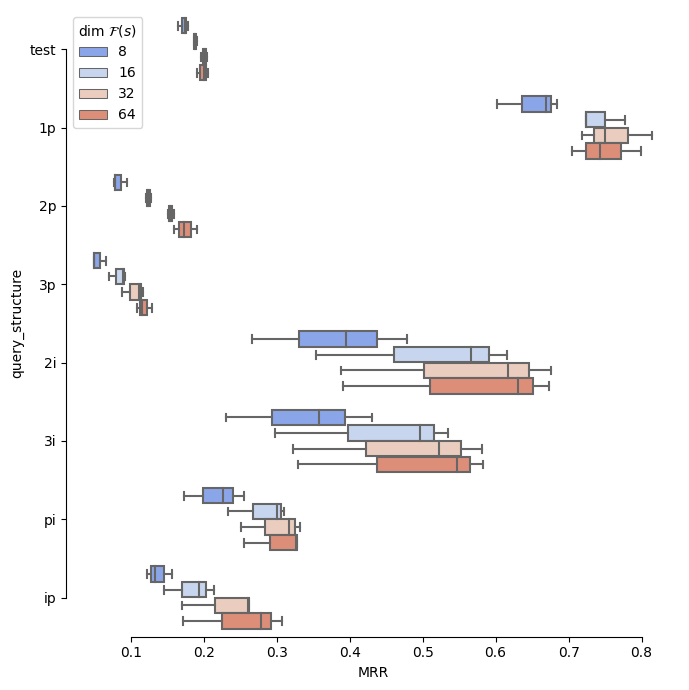

In [8]:
this_metric_dfs = metric_dfs[(metric_dfs['c0_dim'] == metric_dfs['c1_dim']) & 
                            (metric_dfs['parametrization'] != 'orthogonal') &
                            (metric_dfs['num_sections'] == 32) & 
                            (metric_dfs['reg_weight'] == 0)].copy()

cr = {'c0_dim':'dim $\mathcal{F}(s)$',
        metric:'MRR'}
this_metric_dfs.rename(cr, axis=1, inplace=True)

g = sns.catplot(
    data=this_metric_dfs, kind="box",
    x=cr[metric], y='query_structure', hue=cr['c0_dim'],
    palette="coolwarm", height=7, legend_out=False
)
sns.despine(trim=True)
plt.tight_layout()
plt.show()

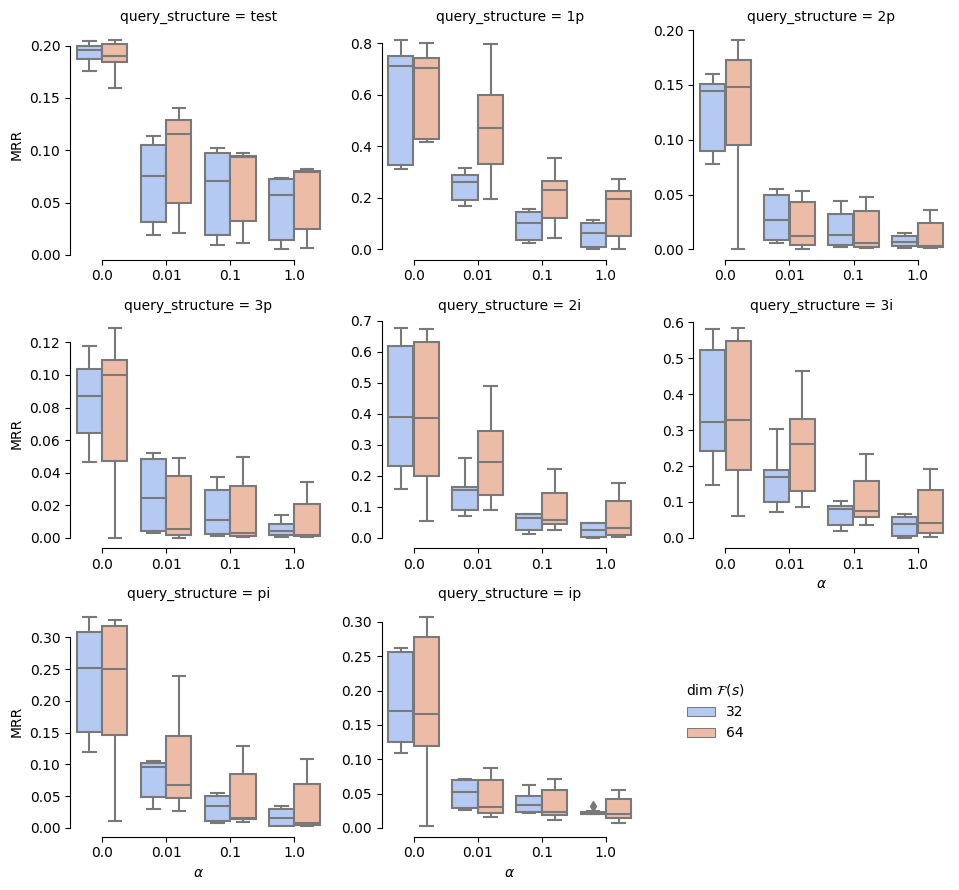

In [9]:
this_metric_dfs = metric_dfs[(metric_dfs['c0_dim'] == metric_dfs['c1_dim']) & 
                            (metric_dfs['c0_dim'] >= 32) & (metric_dfs['parametrization'] != 'orthogonal')
                            ].copy()

cr = {'c0_dim':'dim $\mathcal{F}(s)$',
        metric:'MRR',
        'reg_weight':r'$\alpha$'}
this_metric_dfs.rename(cr, axis=1, inplace=True)

g = sns.catplot(
    data=this_metric_dfs, x=cr['reg_weight'], y=cr[metric], col='query_structure',
    kind="box", height=3, col_wrap=3, hue=cr['c0_dim'], palette='coolwarm', sharex=False, 
    sharey=False,
)
sns.move_legend(g, "upper left", bbox_to_anchor=(.7, 0.25))
sns.despine(trim=True)
plt.tight_layout()
plt.show()

# Naive Baseline Table

In [10]:
c0_dim_baseline = 32
c1_dim_baseline = 32
num_sections_baseline = 1
seed_baseline = 134
parametrization_baseline = None
reg_weight_baseline = 0
num_epochs_baseline = 250
difficulty_baseline = 'easy'

naive_loc = result_loc.format(dataset, 'BetaeNaiveTransE', seed_baseline, c0_dim_baseline, c1_dim_baseline, num_sections_baseline, parametrization_baseline, reg_weight_baseline, num_epochs_baseline, difficulty_baseline)
transe_loc = result_loc.format(dataset, 'BetaeExtensionTransE', seed_baseline, c0_dim_baseline, c1_dim_baseline, num_sections_baseline, parametrization_baseline, reg_weight_baseline, num_epochs_baseline, difficulty_baseline)
se_loc = result_loc.format(dataset, 'BetaeExtensionStructuredEmbedding', seed_baseline, c0_dim_baseline, c1_dim_baseline, num_sections_baseline, parametrization_baseline, reg_weight_baseline, num_epochs_baseline, difficulty_baseline)

df_naive = pd.read_csv(naive_loc)
df_naive['model'] = 'BetaeNaiveTransE'
df_naive['dataset'] = dataset
df_transe = pd.read_csv(transe_loc)
df_transe['model'] = 'ExtensionTransE'
df_transe['dataset'] = dataset
df_se = pd.read_csv(se_loc)
df_se['model'] = 'ExtensionStructuredEmbedding'
df_se['dataset'] = dataset

df_baseline = pd.concat([df_naive, df_transe, df_se], ignore_index=True, axis=0).drop({'Unnamed: 0'}, axis=1)
df_baseline = df_baseline[(df_baseline['Metric'] == metric) & (df_baseline['Type'] == metric_type) & (df_baseline['Side'] == side)].rename({'Value':metric}, axis=1)

In [11]:
df_baseline.set_index(['dataset','model','query_structure'])[metric].unstack('query_structure')

query_structure                               1p        2i        2p  \
dataset   model                                                        
FB15k-237 BetaeNaiveTransE              0.336776  0.162774  0.079082   
          ExtensionStructuredEmbedding  0.310777  0.231546  0.077831   
          ExtensionTransE               0.326013  0.157034  0.084412   

query_structure                               3i        3p        ip  \
dataset   model                                                        
FB15k-237 BetaeNaiveTransE              0.167048  0.052325  0.049463   
          ExtensionStructuredEmbedding  0.241529  0.046421  0.124809   
          ExtensionTransE               0.147155  0.050362  0.108524   

query_structure                               pi      test  
dataset   model                                             
FB15k-237 BetaeNaiveTransE              0.107054  0.187842  
          ExtensionStructuredEmbedding  0.151200  0.175387  
          ExtensionTransE               0.119316  0.186839